# 01 - Data Audit

In this notebook we will:
1. Load the raw `Reviews.csv`
2. Inspect shape, columns, and missing values  
3. Visualize STAR‐rating distribution  
4. Compute basic text‐length stats & histograms  
5. Define and count our two simple label schemes (Helpfulness Heuristic & Sentiment Proxy)  


In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# make plots show inline
%matplotlib inline
plt.style.use('ggplot')


In [2]:
# 1) Load data
df = pd.read_csv('../data/Reviews.csv')   # adjust path if needed

# Quick peek
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(3)


Shape: (568454, 10)
Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
# 2) Missing / null values
nulls = df.isnull().sum().sort_values(ascending=False)
pd.DataFrame({'null_count': nulls})


,null_count
Summary,27
ProfileName,26
Id,0
ProductId,0
UserId,0
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Text,0


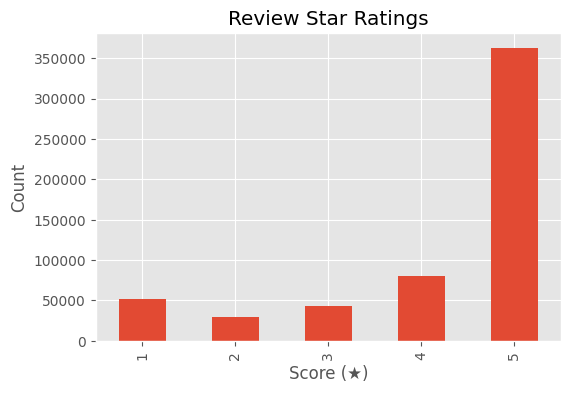

In [4]:
# 3) STAR‐rating distribution
counts = df['Score'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(6,4))
counts.plot.bar(ax=ax)
ax.set_xlabel('Score (★)')
ax.set_ylabel('Count')
ax.set_title('Review Star Ratings')
plt.show()


Char length: count    568454.0
mean        436.2
std         445.3
min          12.0
25%         179.0
50%         302.0
75%         527.0
max       21409.0
Name: char_len, dtype: float64
Word length: count    568454.0
mean         80.3
std          79.5
min           3.0
25%          33.0
50%          56.0
75%          98.0
max        3432.0
Name: word_len, dtype: float64


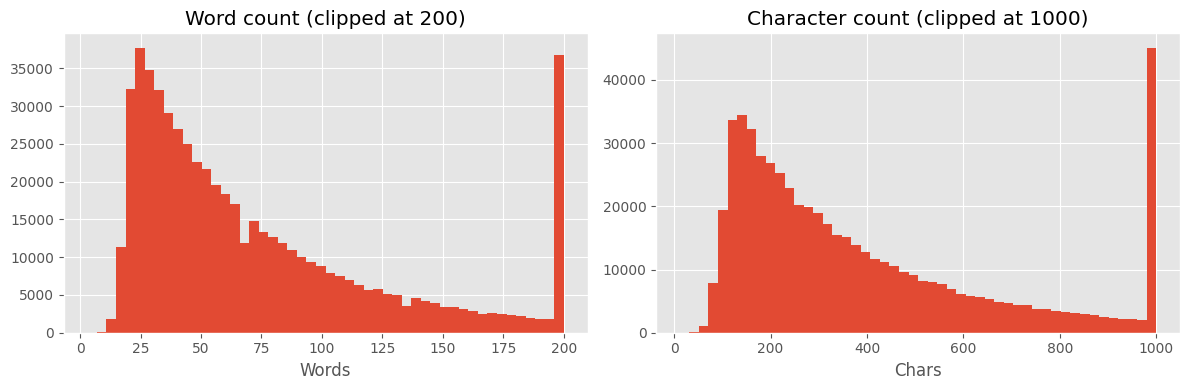

In [5]:
# 4) Text‐length stats
df['char_len'] = df['Text'].str.len()
df['word_len'] = df['Text'].str.split().apply(len)

# summary stats
print("Char length:", df['char_len'].describe().round(1))
print("Word length:", df['word_len'].describe().round(1))

# histograms
fig, axes = plt.subplots(1,2,figsize=(12,4))
df['word_len'].clip(upper=200).hist(bins=50, ax=axes[0])
axes[0].set_title('Word count (clipped at 200)')
axes[0].set_xlabel('Words')

df['char_len'].clip(upper=1000).hist(bins=50, ax=axes[1])
axes[1].set_title('Character count (clipped at 1000)')
axes[1].set_xlabel('Chars')

plt.tight_layout()
plt.show()


## 5) Label schemes

We’ll create two simple binary labels:
- **HH (Helpfulness Heuristic)**  
- **SP (Sentiment Proxy)**


In [6]:
# A) Helpfulness Heuristic (HH)
#   help_ratio = num / denom (denom→1 if zero)
df['help_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'].replace(0,1)
df['hh_label'] = np.where(
    (df['HelpfulnessDenominator']>=5)&(df['help_ratio']>=0.6), 1,
    np.where((df['HelpfulnessDenominator']>=5)&(df['help_ratio']<=0.1)&(df['word_len']<30), 0, np.nan)
)

# B) Sentiment Proxy (SP)
df['sp_label'] = np.where(df['Score'].isin([4,5]), 1,
                          np.where(df['Score'].isin([1,2]), 0, np.nan))

# Count each
counts = pd.DataFrame({
    'HH': df['hh_label'].value_counts(dropna=False),
    'SP': df['sp_label'].value_counts(dropna=False)
})
counts.index = ['neg(0)','pos(1)','NaN']
counts


,HH,SP
neg(0),881,82037
pos(1),52003,443777
NaN,515570,42640


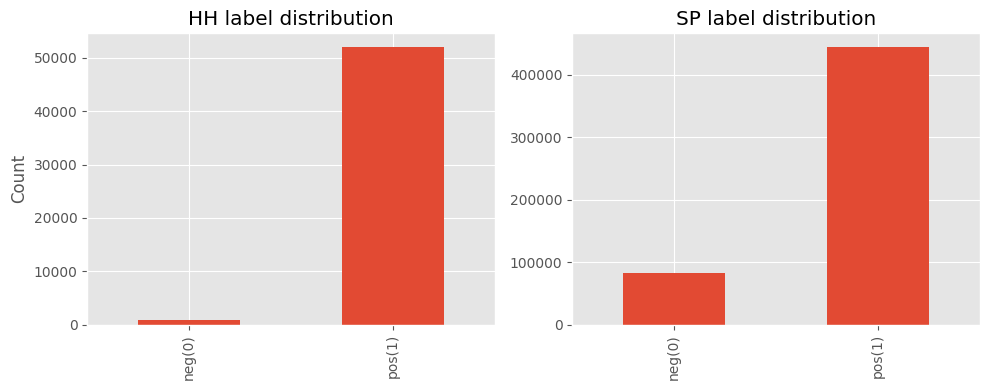

In [7]:
# Bar plots of label distributions
fig, axes = plt.subplots(1,2,figsize=(10,4))
counts['HH'].loc[['neg(0)','pos(1)']].plot.bar(ax=axes[0])
axes[0].set_title('HH label distribution')
axes[0].set_ylabel('Count')

counts['SP'].loc[['neg(0)','pos(1)']].plot.bar(ax=axes[1])
axes[1].set_title('SP label distribution')

plt.tight_layout()
plt.show()


In [8]:
# 6) View some examples
print("HH = 1 (genuine) samples:")
display(df[df['hh_label']==1].sample(3)[['Score','HelpfulnessNumerator','HelpfulnessDenominator','Text']])

print("\nHH = 0 (fake) samples:")
display(df[df['hh_label']==0].sample(3)[['Score','HelpfulnessNumerator','HelpfulnessDenominator','Text']])

print("\nSP = 1 (pos) samples:")
display(df[df['sp_label']==1].sample(3)[['Score','Text']])

print("\nSP = 0 (neg) samples:")
display(df[df['sp_label']==0].sample(3)[['Score','Text']])


HH = 1 (genuine) samples:


,Score,HelpfulnessNumerator,HelpfulnessDenominator,Text
349306,5,8,8,This tea is amazingly delicious. I have always...
12238,1,4,5,all of the veterinary products made in China a...
127682,5,42,42,I have yet to find a superior dry cat food. I ...



HH = 0 (fake) samples:


,Score,HelpfulnessNumerator,HelpfulnessDenominator,Text
453681,1,0,46,I ordered it for healing purposes and it has n...
33953,1,0,5,Are you supposed to avoid sugars if you have a...
11629,1,0,5,These quickly became dog treats! Just nasty! ...



SP = 1 (pos) samples:


,Score,Text
451266,5,"If you research, organic, unrefined cold press..."
564589,5,Great quality at a good price and pure yummine...
266878,5,These taste great! The usual graham crackers ...



SP = 0 (neg) samples:


,Score,Text
398707,2,Have they changed the recipe? These aren't as ...
564381,2,"My dogs love these, but I hate them because th..."
45853,2,"Personally, it tasted too sweet and you could ..."
